# Scoring Auctions

In [1]:
%run publish.py

## Intro Scoring

This chapter studies models devoted to **scoring auctions**, that is, auctions where both price and quality matter. Quality is an abstraction and can take multiple forms such as: experience, preference, social impact, green tech... the nature of it could be different. What matters is that the auctioneer values certain non-monetary outcomes of the auction.

In classic auctions, the idea is that the high-value (in value auctions) or the low-cost (in procurement auctions) firm wins. In scoring auctions, the firm with the best combination of monetary and non-monetary characteristics wins.

Scoring auctions are quite important in the context of procurement. Military, construction, educational and even catering contracts are typically allocated through some sort of a scoring auctions. And even when they are formally not, it still makes sense to model them as such. Yet, the theory of scoring auctions (as of 2021) is somewhat underdeveloped. 

### Goals

The goal of this chapter is to:
1. Introduce a taxonomy of scoring auctions
2. Introduce a family of scoring auction models
3. Characterize equilibria in these models
4. Learn to model and compare auction outcomes

### Assets

There is a handful of papers on the topic
1. [Design Competition Through Multidimensional Auctions, RAND, 1993](https://github.com/pandreyanov/grad_micro_lectures/blob/main/_assets/papers/scoring_auctions/che93.pdf)
2. [Properties of scoring auctions, RAND, 2008](https://github.com/pandreyanov/grad_micro_lectures/blob/main/_assets/papers/scoring_auctions/asker08.pdf)
3. [Procurement when price and quality matter, RAND, 2010](https://github.com/pandreyanov/grad_micro_lectures/blob/main/_assets/papers/scoring_auctions/asker10.pdf)
4. [My dissertation, Chapter 1](https://github.com/pandreyanov/grad_micro_lectures/blob/main/_assets/papers/scoring_auctions/my_diss.pdf)
5. [Handbook of Procurement, Chapter 12](https://github.com/pandreyanov/grad_micro_lectures/blob/main/_assets/papers/scoring_auctions/handbook_procurement.pdf)
6. [An empirical study of scoring auctions and quality manipulation corruption, EER, 2019](https://github.com/pandreyanov/grad_micro_lectures/blob/main/_assets/papers/scoring_auctions/huang19.pdf)

## General Ideas

### Scoring rules

We start with a loose definition of a scoring auction in a procurement environment

!!! warning "Definition"

    A **scoring auction** is an auction where the winner is determined not by the strongest bid, but by the strongest  **score** - a function of bid and certain quality characteristics. A function that compiles bid and quality into a score is called a **scoring rule**.

??? quote "Read from Handbook of Procurement"

    When quality is a crucial component of a procurement contract and flexibility is needed to handle the trade-off between price and quality, scoring mechanisms are particularly appropriate. Should this be the case, pro-curement contracts for goods and services are awarded taking into accountsome non-price attributes that include various measures of quality... For instance, in the procurement of personal computers, hard disks, screen dimension, weight, etc., are valuable technical aspects for end-users, and the buyer is likely to take them into account in the design of the procurement strategy

A scoring rule can take one of the following forms

1. **linear** score $s = \alpha q + d$
2. **quality-to-price ratio** $s = q/b$
3. multiplicative score $s = q d$
4. log-linear score $s = q^{\alpha} d$
5. **interdependent** scores like $s = \alpha q/q_{max} + d$ and many others

where $r$ is the **reserve price**, sometimes referred to as *starting price* or *maximal price*, and $d = r - b$ is the **discount**, and $d/r$ is the **percentage discount**.

!!! note

    Scoring rules are defined up to a monotone transformation, so 

    $$s = - b/q, \quad s = q/b, \quad s = \log q - \log b$$ 

    are the same scoring rule really.

What we refer to as **quality** is also often multi-dimensional, in which case we interpret $q$ as a *quality index* - typically a weighted average of multiple quality characteristics. To grasp what a typical data generated by a scoring auction could look like, consider a simulation below:

In [2]:
columns = ['q-year', 'q-exp', 'q-prop', 
           'q-index', 'bid', 'reserve', 'score']

size = 1000

y = np.random.randint(1,10,size)
e = np.random.randint(0,100,size)
p = np.random.randint(0,100,size)
q = .1*y/10 + .5*e/100 + .4*p/100
b = np.maximum(100, np.round(1000*q + 100*np.random.normal(0,1,size), 2))
r = np.round(np.ones(size)*np.max(b) + np.random.uniform(0, 1000, size), 2)
s = np.round(.3*q + .7*(r-b)/r, 2)

df = pd.DataFrame(np.vstack((y,e,p,q,b,r,s)).T, columns = columns)

publish(df.head())

+----+----------+---------+----------+-----------+--------+-----------+---------+
|    |   q-year |   q-exp |   q-prop |   q-index |    bid |   reserve |   score |
+====+==========+=========+==========+===========+========+===========+=========+
|  0 |        3 |      51 |        9 |     0.321 | 336.81 |   1707.16 |    0.66 |
+----+----------+---------+----------+-----------+--------+-----------+---------+
|  1 |        2 |      64 |       29 |     0.456 | 417.98 |   1687.82 |    0.66 |
+----+----------+---------+----------+-----------+--------+-----------+---------+
|  2 |        5 |      91 |        7 |     0.533 | 472.55 |   1581.81 |    0.65 |
+----+----------+---------+----------+-----------+--------+-----------+---------+
|  3 |        3 |      82 |       61 |     0.684 | 697.51 |   1443.08 |    0.57 |
+----+----------+---------+----------+-----------+--------+-----------+---------+
|  4 |        2 |      16 |        6 |     0.124 | 105.11 |   1208.75 |    0.68 |
+----+----------

In the table above we have three underlying quality characteristics: *q_year* (years in the market), *q_exp* (experience), *q_prop* (proposition), that are weighted into a single quality index *q_index*. This index is then weighted against the discount, which is not present in the table explicitly. Note that you do not need to have access to all of the variables, some of them are clearly linearly dependent. Alternatively, you might not know the scoring rule, in which case you have to guess it from the data.

Let's see how our simulated data is distributed:

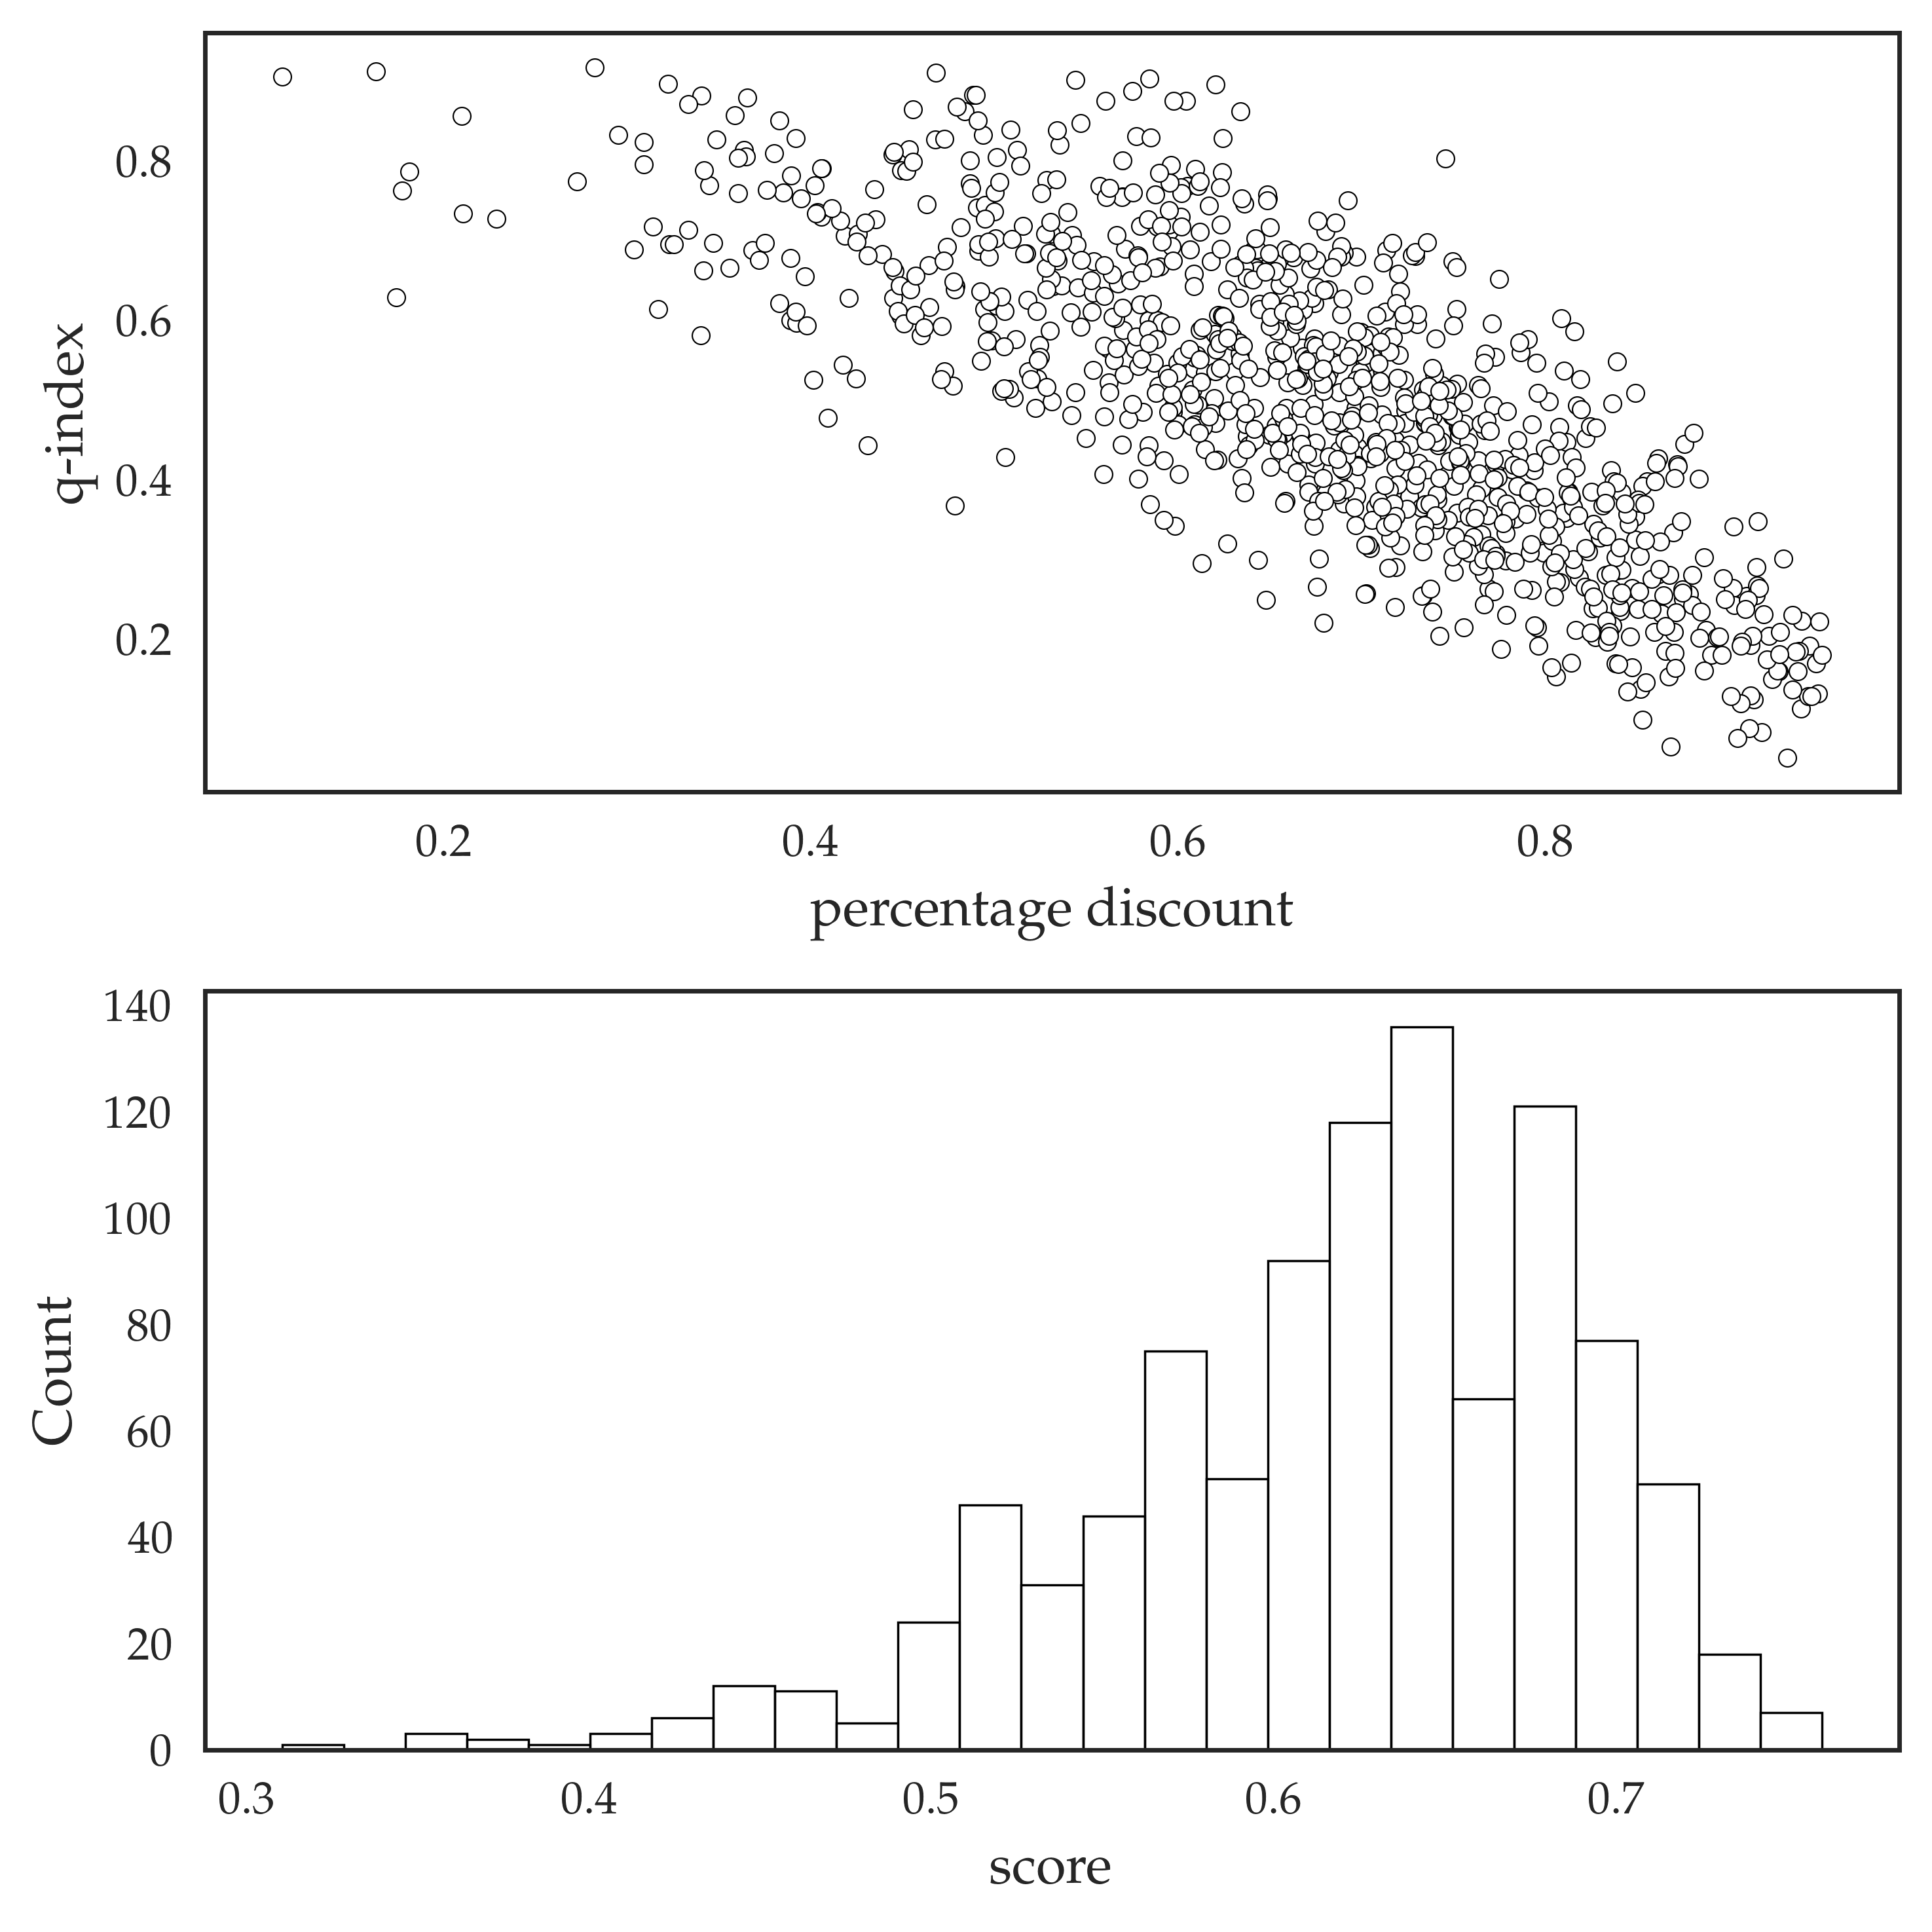

In [3]:
fig, (ax1, ax2) = plt.subplots(2,1)

df['percentage discount'] = (df.reserve - df.bid)/df.reserve

sb.scatterplot(x = 'percentage discount', y = 'q-index', data = df, ax = ax1, **options_scatter);
sb.histplot(df.score, ax = ax2, **options_hist);

publish(fig)

It is natural to expect that quality and discount should be negatively correlated as higher quality is associated with higher costs. However, in practice, the correlation can be actually positive due to strategic reasons (non-monotonicity of monopoly price in demand).

!!! danger

    The theory of **interdependent scoring rules** is very difficult.

### Nature of quality

The quality characteristics can be of different nature. For example, some of them could be completely **exogenous**, like the number of years firm has been operating on the market. These are ojective characteristics of the firm and can not be changed. An example of **endogenous** quality is when the firm submits the number of days needed to complete a certain construction project. The firm has complete freedom to claim any number of days: 30, 100, 300... but her associated costs would probably be higher as well. It is not always possible to say with complete certainty whether quality is exogenous or endogenous.

Another problem is that quality is not always completely objective and therefore is subject to **manipulation** (i.e. corruption), see, for example, [An empirical study of scoring auctions and quality manipulation corruption, EER, 2019](https://github.com/pandreyanov/grad_micro_lectures/blob/main/_assets/papers/scoring_auctions/huang19.pdf). When the risk of manipulation is low, it is possible to not commit to any particular evaluation criteria, or announce the criteria afted the proposals were submitted, so that the buyer has the last word. When the risk of manipulation is high, it makes more sense to commit to  strict and standardized evaluation criteria.

??? quote "Read from Handbook of Procurement"

    Detailed ex-ante specifications increase the predictability of procurement competition, minimizing risks of discretionary behaviour and abuses of the evaluating committee (e.g., corruption). This comes at the cost of losing some flexibility. Therefore, the buyer should carefully evaluate and compare case by case costs and benefits of both flexibility and predictability. When corruption is not a particular concern and participants can offer different valuable solutions for the good or service to be procured, it is more likely that benefits from flexibility prevail. In this case, there can be much to gain from ex-post evaluation. In contrast, if corruption during the evaluation process is a concern, ex-post flexibility should be minimized either by adopting an ex-ante BME (automatic scoring) or, in case this were not possible, by reducing the weight given to technical attributes.

Yet another problem is that certain quality characteristics and highly endogenous, but the associated costs are **sunk costs**, that is, they are incurred independently of the fact whether the firm wins the auction or not. Most of the time we would like the costs to be not sunk, that is, if the firm loses the auction, she can recover most of her investments. An exception is costs associated with mechanically filing the application. Since they do not vary across the firms, these are called **entry costs**.

!!! danger

    The theory of scoring auctions with **sunk costs**, other than **entry costs**, is very difficult.

As an exercise, speculate, where do these quality characteristics:

- number of contracts in the past
- access to special equipment (crane)
- access to skilled labor (architect)
- design blueprints (fighter jet, nuclear plant, bridge)
- design prototype (same)

belong on the spectrum between exogenous and endogenous, sunk and manipulable.

## Linear score

### A simple model

We start with a simplest model where quality is exogenous.

!!! warning "Model summary"

    - quality is exogenous and verifiable
    - there are $n$ ex-ante identical firms
    - each firm maximizes her expected utility $(b-c) \cdot P(win|b, q)$
    - there is a joint distribution of firms costs and quality $F(c, q)$
    - the mechanism is a first-score auction
    - the score is linear $s = \alpha q + (r - b)$

We wish to characterize a symmetric Bayes-Nash equilibrium, that is, our answer should be an equilibrium bidding strategy $\beta(c, q)$.

### Compilation code

In [4]:
%%capture
%%bash 
cd ../; jupyter nbconvert --to markdown docs/*.ipynb; mkdocs build; mkdocs gh-deploy